In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, x_in, x_out):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(x_in, x_out)
    self.activation = nn.Sigmoid()
  def forward(self, x):
    z = self.linear(x)
    a = self.activation(z)
    return a

In [ ]:
model = LogisticRegression(2, 1).train()

In [ ]:
for name, param in model.named_parameters():
  print('===============================')
  print(name)
  print(param.shape)
  print(param)

linear.weight
torch.Size([1, 2])
Parameter containing:
tensor([[-0.5204, -0.2723]], requires_grad=True)
linear.bias
torch.Size([1])
Parameter containing:
tensor([0.1896], requires_grad=True)


In [ ]:
#  L1 loss in LogisticRegression
print(model.linear.weight)
print(model.linear.weight.abs().sum())
#  loss = loss + lambda * reg/(totalnum * 2)

Parameter containing:
tensor([[-0.5204, -0.2723]], requires_grad=True)
tensor(0.7927, grad_fn=<SumBackward0>)


In [ ]:
#  L2 loss in LogisticRegression
print(model.linear.weight)
print(model.linear.weight.pow(2.0).sum())
#  loss = loss + lambda * reg/(totalnum * 2)

Parameter containing:
tensor([[ 0.2826, -0.4775]], requires_grad=True)
tensor(0.3079, grad_fn=<SumBackward0>)


In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

In [61]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [62]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [63]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_dataset = torchvision.datasets.CIFAR10(root="CIFAR10/",
                                             train = True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root="CIFAR10/",
                                             train = False,
                                             transform=transform,
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [64]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size)


In [70]:
class Model(nn.Module):
  def __init__(self, drop_prob):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(32*32*3, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 64)
    self.linear4 = nn.Linear(64, 32)
    self.linear5 = nn.Linear(32, 16)
    self.linear6 = nn.Linear(16, 10)

    self.dropout = nn.Dropout(drop_prob)
    self.activation = nn.Sigmoid()

  def forward(self, x):
    z1 = self.linear1(x)
    a1 = self.activation(z1)
    a1 = self.dropout(a1)

    z2 = self.linear2(a1)
    a2 = self.activation(z2)
    a2 = self.dropout(a2)

    z3 = self.linear3(a2)
    a3 = self.activation(z3)
    a3 = self.dropout(a3)

    z4 = self.linear4(a3)
    a4 = self.activation(z4)
    a4 = self.dropout(a4)

    z5 = self.linear5(a4)
    a5 = self.activation(z5)
    a5 = self.dropout(a5)

    z6 = self.linear6(a5)

    #  Q) why no activation function?
    #  Cross-Entropy Loss를 적용하기 위해서는 Softmax를 우선 해줘야 하나 생각할 수 있는데
    #  PyTorch에서는 softmax와 cross-entropy를 합쳐놓은 것 을 제공하기 때문에 맨 마지막 layer가 softmax일 필요가 없습니다.

    return z6

In [71]:
model = Model(0.2).to(device).train()
#  logistic_model = LogisticRegression(2,1).to(device).train()

#  print(logistic_model.linear.weight)

#  Q) it changes.. although we fixed the seeds.

In [72]:
optimizer = optim.Adam(params=model.parameters(), lr = 1e-3, betas=(0.9, 0.999)) #  set optimizer

In [73]:
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 70
lmbd = 0.003

train_avg_costs = []
test_avg_costs = []

test_total_batch = len(test_dataloader)
total_batch_num = len(train_dataloader)

for epoch in range(epochs):
  avg_cost = 0
  model.train()

  for b_x, b_y in train_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device) # 1 step 마다 batch size만큼의 데이터 사용
    logits = model.forward(b_x)
    loss = criterion(logits, b_y.to(device))

    reg = model.linear1.weight.pow(2.0).sum()
    reg += model.linear2.weight.pow(2.0).sum()
    reg += model.linear3.weight.pow(2.0).sum()

    loss += ((lmbd * reg) / (len(b_x) * 2))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch_num
  train_avg_costs.append(avg_cost.detach().cpu().numpy())
  print('Epoch: {} / {}, cost: {}'.format(epoch + 1, epochs, avg_cost))

  test_avg_cost = 0
  model.eval()
  for b_x, b_y in test_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    with torch.no_grad():
      logits = model(b_x)
      test_loss = criterion(logits, b_y.to(device))
    test_avg_cost += test_loss / test_total_batch
  test_avg_costs.append(test_avg_cost.detach().cpu().numpy())
  

import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

Epoch: 1 / 70, cost: 2.225987672805786
Epoch: 2 / 70, cost: 2.07818341255188
Epoch: 3 / 70, cost: 2.0395212173461914
Epoch: 4 / 70, cost: 2.008033514022827
Epoch: 5 / 70, cost: 1.9684134721755981
Epoch: 6 / 70, cost: 1.9426189661026
Epoch: 7 / 70, cost: 1.9259711503982544
Epoch: 8 / 70, cost: 1.9091006517410278
Epoch: 9 / 70, cost: 1.8944997787475586
Epoch: 10 / 70, cost: 1.8816345930099487
Epoch: 11 / 70, cost: 1.8651118278503418
Epoch: 12 / 70, cost: 1.8564151525497437
Epoch: 13 / 70, cost: 1.8448517322540283
Epoch: 14 / 70, cost: 1.8351620435714722
Epoch: 15 / 70, cost: 1.8294448852539062
Epoch: 16 / 70, cost: 1.8209619522094727
Epoch: 17 / 70, cost: 1.8105279207229614
Epoch: 18 / 70, cost: 1.8046984672546387
Epoch: 19 / 70, cost: 1.7967829704284668
Epoch: 20 / 70, cost: 1.788616418838501
Epoch: 21 / 70, cost: 1.774387240409851
Epoch: 22 / 70, cost: 1.7737023830413818
Epoch: 23 / 70, cost: 1.7628655433654785
Epoch: 24 / 70, cost: 1.7449463605880737
Epoch: 25 / 70, cost: 1.7460758686

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efef9512350>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efef9512950>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


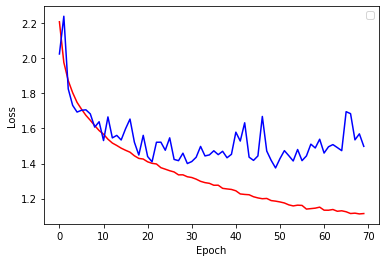

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efef912a450>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efef912aa50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


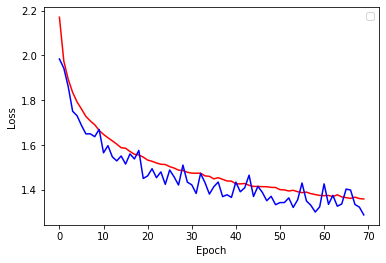

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efef9455090>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efef9455110>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


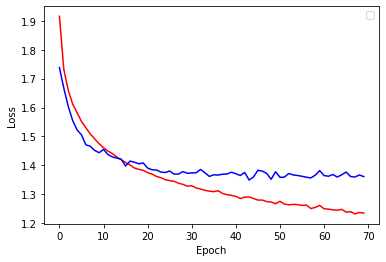

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

In [ ]:
correct = 0
total = 0

model.eval()

for b_x, b_y in test_dataloader:
  b_x = b_x.view(-1, 32*32*3).to(device)

  with torch.no_grad():
    logits = model(b_x)

  probs = nn.Softmax(dim=1)(logits)

  predicts = torch.argmax(probs, dim=1)

  total += len(b_y)
  correct += (predicts == b_y.to(device)).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 51.01%
